#Price Optimization for Apparel Retail Using Google Vertex AI

This notebook is a starter kit for implementing retail price optimization models using Vertex AI. It is designed as a pipeline with the following steps:
1. Initialization and authentification
1. Setting global variables
1. Training the demand foreasting model on historical price and sales data. For the demonstration purposes, we use a semi-synthetic dataset created based on statistics obtained from the real data.
1. Prediction of sales for several time intervals and prices points within the specified forecasting horizon.
1. Finding the optimal prices that maximize the profit for each time interval.
1. Demonstration of the joint optimization of prices for multiple SKUs. This part can potentially be used for modeling of cross-SKU effects like cannibalization (negative interaction) and halo (positive interaction).

The notebook is supposed to be run by Google Collaboratory.


# Initialization

In this section, we perfom basic initialization and set some variables.

In [ ]:
#
# Reinstall google-cloud-aiplatform
#
!pip3 uninstall -y google-cloud-aiplatform
!pip3 install google-cloud-aiplatform

import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

In [ ]:
#
# Authentication
#
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

In [1]:
#
# Set some global variables with your project details and other information:
#
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y_%m_%d_%H%M%S")

REGION = "us-central1"
PROJECT_ID = "hybrid-vertex"
BUCKET_NAME = "gdynamics-price-opt"
DATA_FOLDER = "data"
BASENAME = "jtv1"  # will be used for display-names, some file-names

TIMESTAMP

'2023_04_06_033201'

In [2]:
#
# Initialize AI platform:
#
from google.cloud import aiplatform
import os

aiplatform.init(project=PROJECT_ID, staging_bucket=BUCKET_NAME)
os.environ["GCLOUD_PROJECT"] = PROJECT_ID

# Data Loading and Visualization

In this section, we prepare and load the data needed for model training. We also configure the profit function needed for forecasting, analysis, and optimization.

### Prepare data

To use this notebook, the following data need to be prepared:
1. A CSV-file (named as *-train.csv) with historical sales data for individual SKUs.

1. A CSV-file (named as *-pred.csv) with (1) the observed data to be used for forecast (the context window) and (2) the rows corresponding to the forecast horizon, where the values of the target column (`"sales"`) to be predicted are set to NULL (empty fields in the CSV-file).

Both files have to have the same schema that meets the following requirements:

* The sales date is specified in the column `"date"`

* Each time series has an unique identifier in the column `"id"`

* In the second file (*-pred.csv), each SKU-price combination corresponds to a separate time series. For example, 400 SKUs and 15 relative prices for which the sales volume has be predicted result in 6000 time series.

* Prices in the `"price"` column are given in relative units, i.e. `price_in_dollars/cost_in_dollars`.

* The cost of each SKU are specified in the column `"cost`" and should be in dollars.

Both CSV-files should be uploaded to the GCS-bucket. Variables CSV_TRAIN and CSV_PRED composed in the next code cell should be correct GCS-paths to your files.


---


Example data files: [example-train.csv](https://drive.google.com/file/d/1iM-x6Xk9Ebgk78nb0LGLZn1-Qa874dL1/view?usp=sharing) and [example-pred.csv](https://drive.google.com/file/d/1QU2YEGyqsnjnpdX1wFQRUyeAzdeoRrMq/view?usp=sharing)

In [3]:
#
# Set GCS paths to the data CSV-files and create the training dataset
#

import os

CSV_TRAIN = os.path.join("gs://", BUCKET_NAME, DATA_FOLDER, f"{BASENAME}-train.csv")
CSV_PRED = os.path.join("gs://", BUCKET_NAME, DATA_FOLDER, f"{BASENAME}-pred.csv")

TRAIN_DATASET = aiplatform.TimeSeriesDataset.create(
    display_name=f"{BASENAME}-dataset", gcs_source=[CSV_TRAIN])

Creating TimeSeriesDataset
Create TimeSeriesDataset backing LRO: projects/934903580331/locations/us-central1/datasets/4860252612118708224/operations/7379011443846283264
TimeSeriesDataset created. Resource name: projects/934903580331/locations/us-central1/datasets/4860252612118708224
To use this TimeSeriesDataset in another session:
ds = aiplatform.TimeSeriesDataset('projects/934903580331/locations/us-central1/datasets/4860252612118708224')


### Load data

Read the training dataset as a Pandas DataFrame from the bucket

In [4]:
#
# Read the training dataset as a Pandas DataFrame from the bucket
#
import pandas as pd
from google.cloud import storage
from io import BytesIO
#pd.options.mode.chained_assignment = None

def read_csv_from_bucket(gcs_path, bucket_name=BUCKET_NAME):
    # Get the blob:
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob_name = gcs_path.replace(f"gs://{bucket_name}/", "")
    blob = bucket.blob(blob_name)

    # Convert to DataFrame:
    contents = blob.download_as_string()
    csv_data = BytesIO(contents)
    return pd.read_csv(csv_data, parse_dates=["date"])


df_train = read_csv_from_bucket(CSV_TRAIN)

#
# Check the output for the number of SKUs and the
# names of the fields found in the file
#
print(f" ==> {len(df_train)} rows are read from '{CSV_TRAIN}'")
print(f"  -> {len(df_train['sku_name'].unique())} SKUs are found")
print(f"  -> date from: {df_train['date'].min()}")
print(f"  -> date   to: {df_train['date'].max()}")
print("  -> Columns:")
for i, col_i in enumerate(df_train.columns):
    print(f"    {i:02d}.  {col_i}")

 ==> 291200 rows are read from 'gs://gdynamics-price-opt/data/jtv1-train.csv'
  -> 400 SKUs are found
  -> date from: 2018-06-24 00:00:00
  -> date   to: 2020-06-20 00:00:00
  -> Columns:
    00.  date
    01.  id
    02.  sku_id
    03.  price
    04.  sku_name
    05.  gender
    06.  category
    07.  brand
    08.  collection
    09.  price_tier
    10.  style
    11.  cost
    12.  sales


### Specify the profit function

The profit function can be customized to incorporate store costs and other considerations.

In [5]:
def evaluate_profit(row):
    """  In this variant it is assumed that "price" is given relative to the cost, e.g. 1.4 means 40% markup
    """
    profit = (row["price"] - 1.0) * row["cost"] * row["sales"]
    return profit

### Configure visualization

In this cell, we configure the plots and graphical outputs.

In [7]:
#
# Specify the graphical output folder
#
# If the variable `IMAGE_DIR` is set (not None) and the folder does not exists,
# then (1) the folder will be created, (2) your Google-drive will be mounted and
# the current working directory changed to `IMAGE_DIR`, (3) each graphical
# output will be saved to a separate image file besides the visualization
# within the notebook.
import matplotlib.pyplot as plt

IMAGE_DIR = f"images/images-{BASENAME}"  # if not None, then graphical output is saved to image-files too
IMAGE_PREFIX = "img-"
IMAGE_POSTFIX = ".png"

# if IMAGE_DIR is not None:
#     from google.colab import drive
#     drive.mount('/content/drive')
#     %mkdir -p /content/drive/My\ Drive/{IMAGE_DIR}
#     %cd /content/drive/My\ Drive/{IMAGE_DIR}
#     !pwd


# Set plotting parameters for `matplotlib`
#
# These parameters will affect the graphical
# output in all the cells below.
# You may copy this whole cell (or some commands) to another place and edit
# them. This will affect graphical output in all the next cells.

# To change plotting parameters for particular plotting cells:
#   1. copy all or particluar lines below to a new code cell
#      immediately preceeding the plotting cell;
#   2. edit the values of the parameters of interest
#   3. NB: the parameters have effect in all plotting cells below

HSPACE = 0.7  # increase to avoid vertical overlap
FIG_SIZE = (14, 8)
plt.rc("figure", figsize=FIG_SIZE)
plt.rc('font', size=14)          # controls default text sizes
plt.rc('axes', titlesize=14)   # fontsize of the axes title
plt.rc('axes', labelsize=14)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=14)  # fontsize of the figure title

### Plot the training dataset

We visualize a subset of the training data.


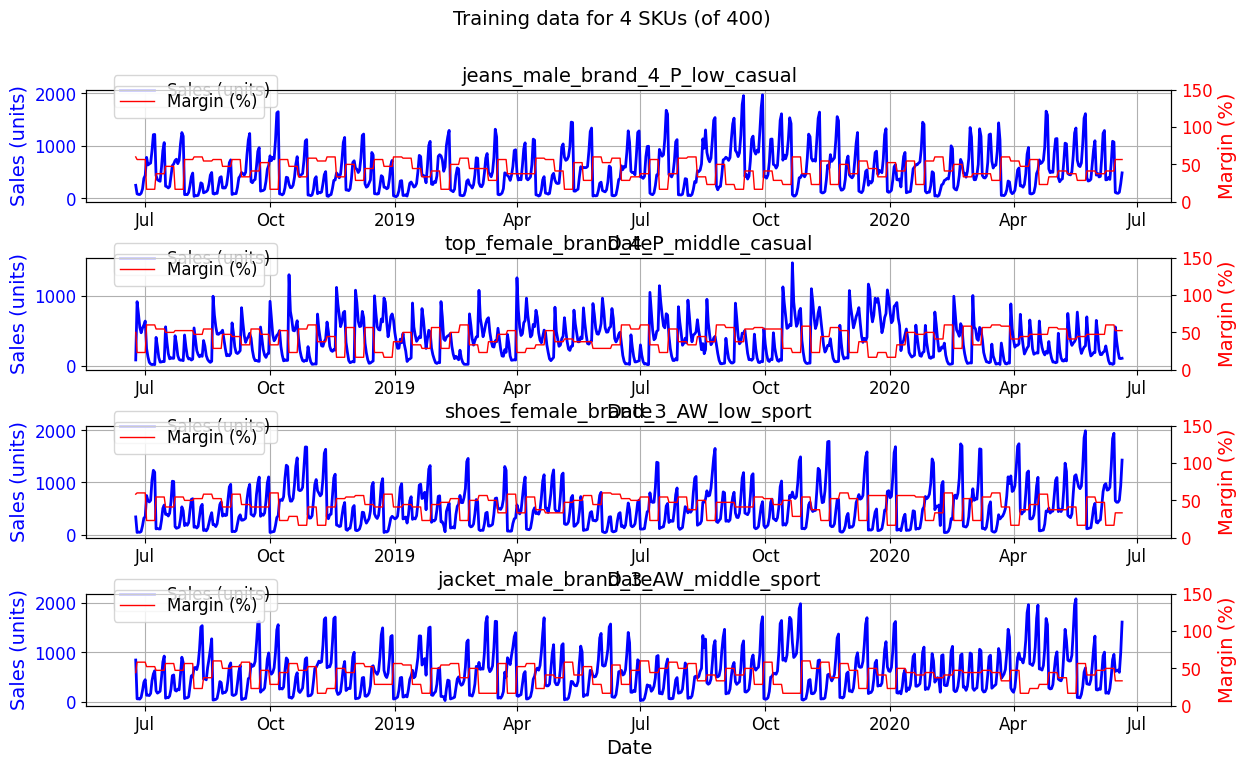

 ==> image saved to img-01-training_data.png


In [8]:
#
# Plot the training dataset: sales & margin as functions of "date"
#
# Margin is calculated as follows: `(price - 1.0) / price * 100%`
#
import numpy as np
import pandas as pd
import sys
import os
import csv
import datetime


import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy import interpolate

MAX_MARGIN = 150

def plot_ax_margin_sales(ax, df, title):
    global SALES_COLOR
    global SALES_LW  # line width
    global PRICE_COLOR
    global PRICE_LW  # line width
    global MAX_MARGIN

    assert "price" in df.columns
    assert "sales" in df.columns
    if "sku_name" in df.columns:
        # Ensure single SKU data
        assert len(df["sku_name"].unique()) == 1

    xlabel = "Date"
    ylabel1 = "Sales (units)"
    ylabel2 = "Margin (%)"

    # Make a new column "margin":
    df["margin"] = (df["price"] - 1.0) / df["price"]

    x = df["date"]
    y_sales = df["sales"].values
    y_margin = df["margin"].values * 100

    #  Plot sales:
    ax.xaxis.set_major_formatter(
        mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.grid()
    ax.set_ylabel(ylabel1, color=SALES_COLOR)
    ax.tick_params(axis='y', labelcolor=SALES_COLOR)
    ax.plot(x, y_sales, '-', lw=SALES_LW, color=SALES_COLOR, label=ylabel1)

    # Plot price margin (as Y2):
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel(ylabel2, color=PRICE_COLOR)
    ax2.set_ylim(0, MAX_MARGIN)
    ax2.tick_params(axis='y', labelcolor=PRICE_COLOR)
    ax2.plot(x, y_margin, color=PRICE_COLOR, lw=PRICE_LW, label=ylabel2)

    ax.legend(loc=(0.025, 0.85))
    ax2.legend(loc=(0.025, 0.75))

    return


def plot_margin_sales(df, sku_names, title, img_path=None):
    global FIG_SIZE
    global HSPACE

    n_sku = len(sku_names)

    fig, axs = plt.subplots(ncols=1, nrows=n_sku)
    if title:
        fig.suptitle(title)
    plt.subplots_adjust(wspace=0., hspace=HSPACE)

    for i in range(n_sku):
        #  Select rows only for the i-th SKU:
        sku_i = sku_names[i]
        idx_i = df["sku_name"] == sku_i
        df_i = df[idx_i].copy()

        if n_sku > 1:
            plot_ax_margin_sales(axs[i], df_i, title=f"{sku_i}")
        else:
            plot_ax_margin_sales(axs, df_i, title=f"{sku_i}")

    plt.show()
    if IMAGE_DIR is not None and img_path is not None:
        fig.savefig(img_path, bbox_inches='tight')
        print(f" ==> image saved to {img_path}")

    return


FIG_SIZE = (16, 15)
HSPACE = 0.5

SALES_COLOR = "blue"
PRICE_COLOR = "red"

SALES_LW = 2
PRICE_LW = 1

sku_names = [
    "jeans_male_brand_4_P_low_casual",
    "top_female_brand_4_P_middle_casual",
    "shoes_female_brand_3_AW_low_sport",
    "jacket_male_brand_3_AW_middle_sport",
]

title = f"Training data for {len(sku_names)} SKUs (of 400)"
img_path = f"{IMAGE_PREFIX}01-training_data{IMAGE_POSTFIX}"
plot_margin_sales(df_train, sku_names, title, img_path)


# Demand Model Training using AutoML Forecasting

You may either specify a readily available Vertex AI model trained earlier (it takes no time) or to train a model from scratch (it takes about 1 hour for the default value `budget_milli_node_hours=1000`)

Be careful with ascribing columns to time series attributes as well as with specifying data types (numerical or categorical).


In [12]:
#
# Train a model in Auto-ML (if MODEL_NAME is None) or get a pre-trained model:
#

# Enter a model name if available: use None for training from scratch
# MODEL_NAME = "2313271309770948608"  # Simply use this model (takes no time)
MODEL_NAME = None  # Train the model from scratch (takes about 1 hour)

forecast_horizon = 14
context_window = 28

model_display_name = f"{BASENAME}-model"

time_column = "date"
time_series_identifier_column="id"
target_column="sales"


# Specify data types of the columns:
numeric_cols = ["sales", "price", "cost"]
categ_cols = [
    "sku_name", "gender", "category", "brand",
     "collection", "price_tier", "style",
]
# Prepare column_transformations list:
column_transformations=[{"timestamp": {"column_name": time_column}}]
for col_i in numeric_cols:
    column_transformations.append({"numeric": {"column_name": col_i}})
for col_i in categ_cols:
    column_transformations.append({"categorical": {"column_name": col_i}})

#  List the covariates available at forecast
#  (only the columns whose values change in time)
available_at_forecast_columns = ["date", "price"]

#  List the attributes, i.e. the variables that
#      do not change in time for any given time series (SKU):
time_series_attribute_columns = ["cost"] + categ_cols

if MODEL_NAME is None or MODEL_NAME == "":

    job = aiplatform.AutoMLForecastingTrainingJob(
        display_name=f'job_train_model-{model_display_name}-{TIMESTAMP}',
        optimization_objective='minimize-rmse',
        column_transformations=column_transformations
    )

    # This will take around an hour to run
    model = job.run(
        dataset=TRAIN_DATASET,
        target_column=target_column,
        time_column=time_column,
        time_series_identifier_column=time_series_identifier_column,
        available_at_forecast_columns=available_at_forecast_columns,
        unavailable_at_forecast_columns=[target_column],
        time_series_attribute_columns=time_series_attribute_columns,
        forecast_horizon=forecast_horizon,
        context_window=context_window,
        data_granularity_unit="day",
        data_granularity_count=1,
        weight_column=None,
        budget_milli_node_hours=1000,
        model_display_name=model_display_name,
        predefined_split_column_name=None,
        sync=False,
    )
else:
    model = aiplatform.Model(MODEL_NAME)

No dataset split provided. The service will use a default split.


/home/jupyter/.local/lib/python3.7/site-packages/google/cloud/aiplatform/training_jobs.py:1764: DeprecationWarning: consider using column_specs instead. column_transformations will be deprecated in the future.
  column_transformations,


View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/4524064150103523328?project=934903580331
AutoMLForecastingTrainingJob projects/934903580331/locations/us-central1/trainingPipelines/4524064150103523328 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLForecastingTrainingJob projects/934903580331/locations/us-central1/trainingPipelines/4524064150103523328 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLForecastingTrainingJob projects/934903580331/locations/us-central1/trainingPipelines/4524064150103523328 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLForecastingTrainingJob projects/934903580331/locations/us-central1/trainingPipelines/4524064150103523328 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLForecastingTrainingJob projects/934903580331/locations/us-central1/trainingPipelines/4524064150103523328 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLForecastingTrainingJob projects/934903580331/lo

# Demand Forecasting and Scenario Evaluation

In this section, we use the trained model to produce demand forecasts for different pricing scenarios.

### Plot sales and margin for one context window

We visualize one context window that will be used an input for the prediction model.

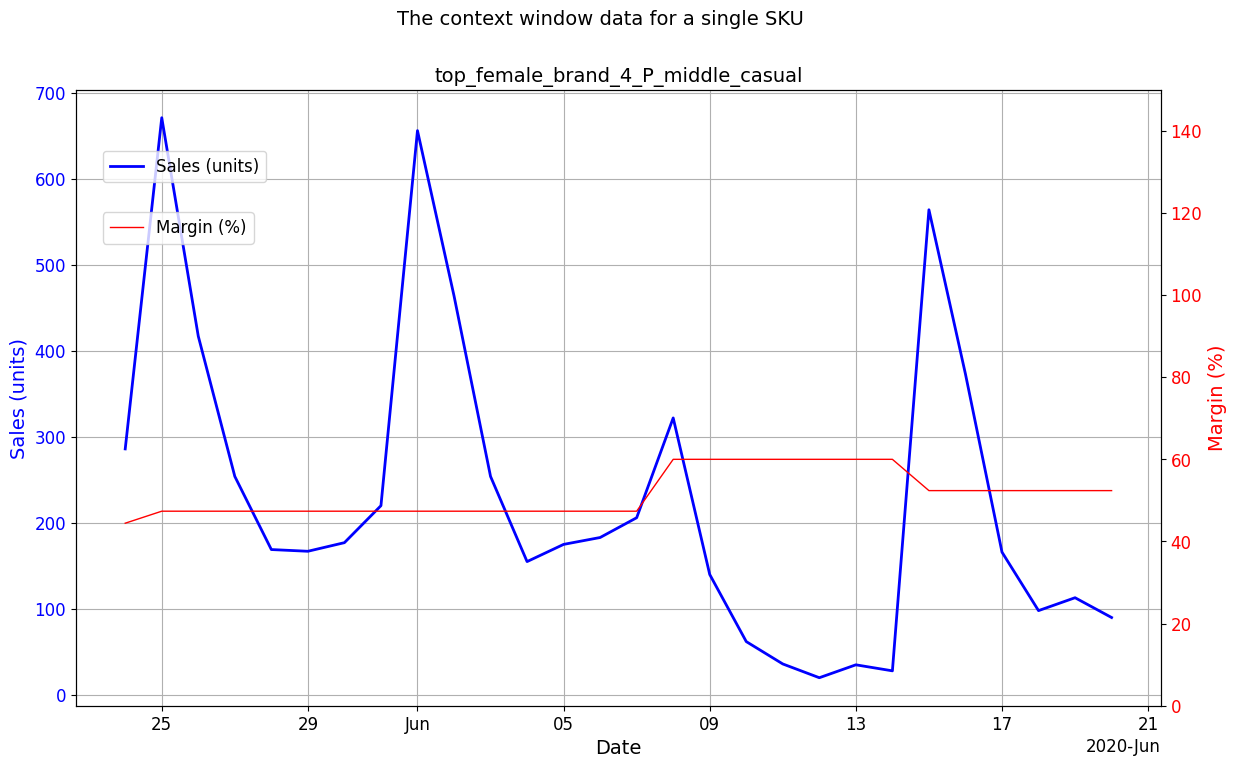

 ==> image saved to img-02-context_window_data.png


In [13]:
#
# Plot sales and margin for a single SKU (context window)
#
SKU_NAME = "top_female_brand_4_P_middle_casual"

# Read *-pred.csv file with the context_window and forecast_horizon dates (for given SKU):
df_pred_orig = read_csv_from_bucket(CSV_PRED)

# Get a single SKU:
idx = df_pred_orig["sku_name"] == SKU_NAME
df_pred_sku = df_pred_orig[idx]

# Get a single time series:
ids = df_pred_sku["id"].unique()
idx = df_pred_sku["id"] == ids[0]
df_pred = df_pred_sku[idx]

# Get only rows corresponding to the context window:
dates = sorted(df_pred["date"].unique())
DATES_WIN = dates[0:context_window]
DATES_PRED = dates[context_window:]
idx = df_pred["date"].isin(DATES_WIN)
df_win = df_pred[idx]

FIG_SIZE = (16, 5)
HSPACE = 0.1

title = f"The context window data for a single SKU"
img_path = f"{IMAGE_PREFIX}02-context_window_data{IMAGE_POSTFIX}"
plot_margin_sales(df_win, sku_names=[SKU_NAME], title=title, img_path=img_path)


### Run the batch-prediction job for the model:
It normally takes 5-10 min

If you know the value of the `gcs_dir` variable for the previously run batch-prediction job, you may skip the cell and to specifiy the value of `gcs_dir` in the very beginning of the next cell - "Plot predicted sales for several margins"


In [14]:
#
# Run the batch-prediction job for the model
#
gsc_output_folder = os.path.join("gs://", BUCKET_NAME, DATA_FOLDER, f"predictions-{TIMESTAMP}")

batch_predict_job = model.batch_predict(
   gcs_source=CSV_PRED,
   instances_format="csv",
   gcs_destination_prefix=gsc_output_folder,
   predictions_format="csv",
   job_display_name=f"job-batch_predict-{BASENAME}-{TIMESTAMP}",
   sync=True
)
batch_predict_job.wait()

gcs_dir = batch_predict_job.gca_resource.output_info.gcs_output_directory
gcs_dir

Creating BatchPredictionJob
BatchPredictionJob created. Resource name: projects/934903580331/locations/us-central1/batchPredictionJobs/2013236989100294144
To use this BatchPredictionJob in another session:
bpj = aiplatform.BatchPredictionJob('projects/934903580331/locations/us-central1/batchPredictionJobs/2013236989100294144')
View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/batch-predictions/2013236989100294144?project=934903580331
BatchPredictionJob projects/934903580331/locations/us-central1/batchPredictionJobs/2013236989100294144 current state:
JobState.JOB_STATE_RUNNING
BatchPredictionJob projects/934903580331/locations/us-central1/batchPredictionJobs/2013236989100294144 current state:
JobState.JOB_STATE_RUNNING
BatchPredictionJob projects/934903580331/locations/us-central1/batchPredictionJobs/2013236989100294144 current state:
JobState.JOB_STATE_RUNNING
BatchPredictionJob projects/934903580331/locations/us-central1/batchPredictionJobs/

'gs://gdynamics-price-opt/data/predictions-2023_04_06_033201/prediction-jtv1-model-2023_04_05T23_13_39_711Z'

In [16]:
batch_predict_bq_output_uri = "{}.{}".format(
    batch_predict_job.output_info.bigquery_output_dataset,
    batch_predict_job.output_info.bigquery_output_table
)

batch_predict_bq_output_uri

'.'

In [18]:
batch_predict_job.output_info

gcs_output_directory: "gs://gdynamics-price-opt/data/predictions-2023_04_06_033201/prediction-jtv1-model-2023_04_05T23_13_39_711Z"

### Plot predicted sales for several margins (prices) for the selected SKU:

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


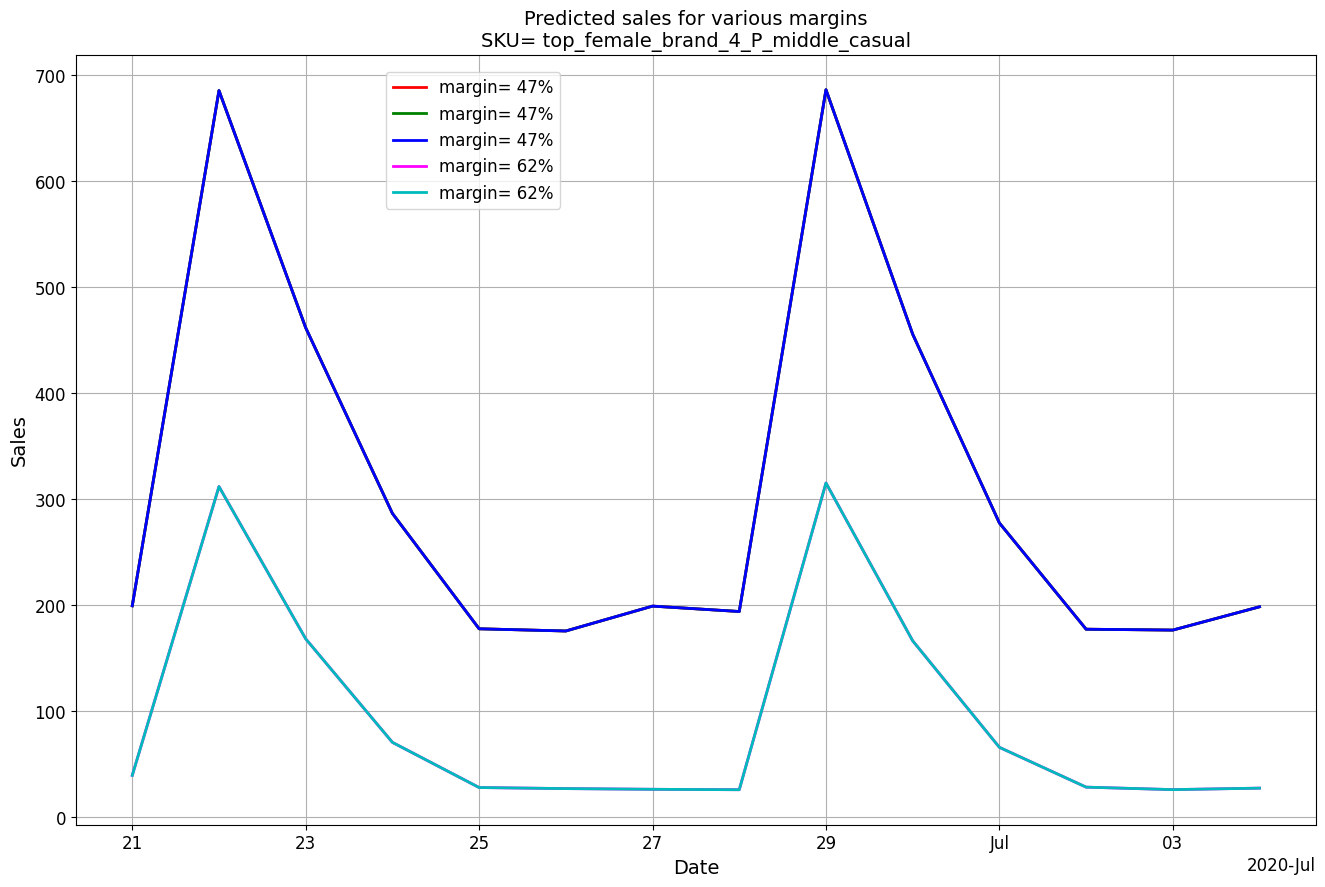

 ==> image saved to img-03-predicted_sales_for_several_margins.png


In [25]:

def plot_ax_sales_n_prices(ax, df):
    df = df.copy().sort_values(["date", "price"])
    assert len(df['sku_name'].unique()) == 1

    # Make a new column "margin":
    df["margin"] = (df["price"] - 1.0) / df["price"]
    prices = df["price"].unique()
    prices = np.sort(prices)
    colors = ["red", "green", "blue", "#FF00FF", "#00BBBB"]

    # vk_remove
    #print(df.dtypes)
    #return

    ncolors = len(colors)
    dp = float(len(prices)) / ncolors
    for i in range(ncolors):
        ii = int(dp * i)
        price_i = prices[ii]
        idx_i = df["price"] == price_i
        df_i = df[idx_i]

        x_i = df_i["date"]
        y_i = df_i["sales"]
        assert len(df_i["margin"].unique()) == 1
        margin_i = df_i["margin"].iloc[0]
        label_i = f"margin= {margin_i*100:.0f}%"

        ax.plot(x_i, y_i, lw=2, ms=2, label=label_i, color=colors[i])

    return

# Read csv-file with predictions into a DataFrame:
# predictions_1.csv
# prediction.results-00000-of-00044.csv

df_predictions = read_csv_from_bucket(gcs_path=gcs_dir + "/prediction.results-00000-of-00044.csv")
df_predictions = df_predictions.sort_values(["sku_name", "date", "price"])

idx_sku = df_predictions["sku_name"] == SKU_NAME
df = df_predictions[idx_sku]
df["sales"] = df["predicted_sales"]

fig_size = (16, 10)
fig, (ax) = plt.subplots(ncols=1, nrows=1, figsize=fig_size)

plot_ax_sales_n_prices(ax, df)

ax.set_title(f"Predicted sales for various margins\nSKU= {SKU_NAME}")
ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.grid()
ax.legend(loc=(0.25, 0.80))
plt.show()
if IMAGE_DIR is not None:
    img_path = f"{IMAGE_PREFIX}03-predicted_sales_for_several_margins{IMAGE_POSTFIX}"
    fig.savefig(img_path, bbox_inches='tight')
    print(f" ==> image saved to {img_path}")


df_n_prices = df.copy()

### Plot observed sales combined with the predicted sales for several prices

The observed sales correspond to the context window

The predicted sales correspond to the days within the forecast horizon

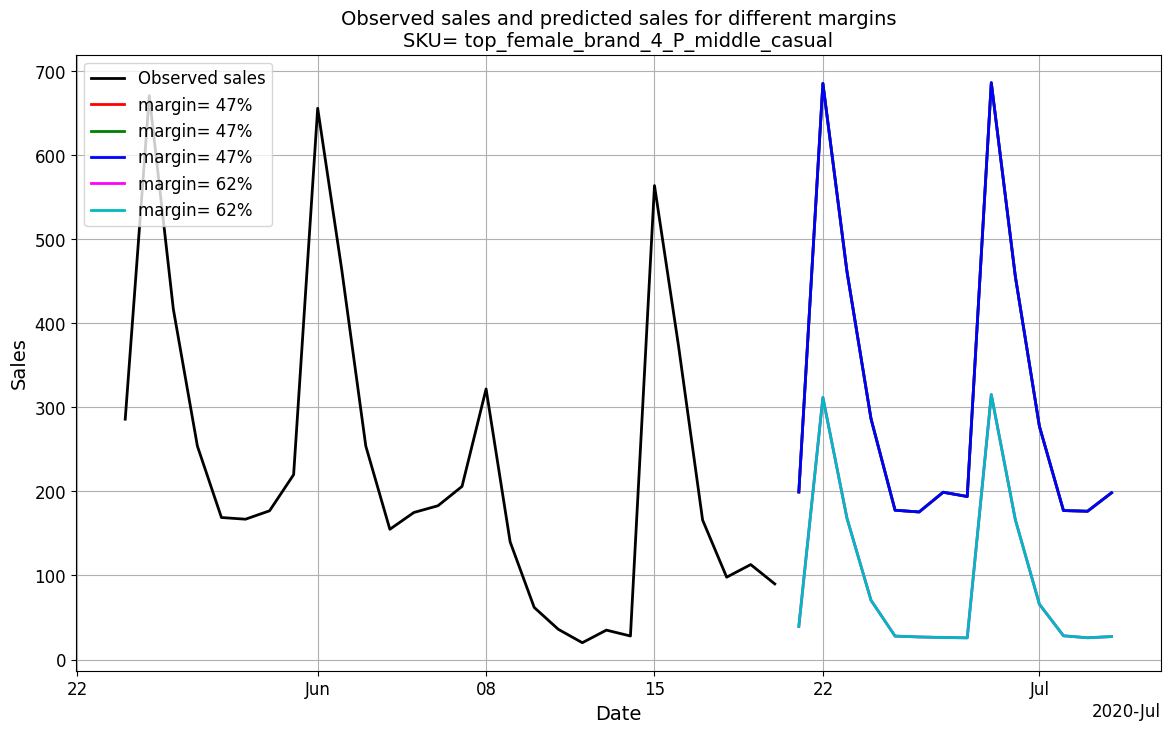

 ==> image saved to img-04-observed_and_predicted_sales.png


In [22]:
#
# Plot observed sales and predicted sales for several prices
#
def plot_ax_sales(ax, df, color, label):
    df = df.copy().sort_values(["date"])
    assert len(df['sku_name'].unique()) == 1
    #assert len(df['price'].unique()) == 1

    x = df["date"]
    y = df["sales"]
    ax.plot(x, y, lw=2, ms=2, label=label, color=color)
    return

idx_sku = df_pred["sku_name"] == SKU_NAME
df = df_pred[idx_sku]

# Get only rows from the contex window:
pred_dates = df_predictions["date"].unique()
idx = df["date"].isin(pred_dates)
df = df[~idx]

fig_size = (14, 8)
fig, (ax) = plt.subplots(ncols=1, nrows=1, figsize=fig_size)
ax.set_title(f"Observed sales and predicted sales for different margins\nSKU= {SKU_NAME}")

#plot_ax_sales_n_prices(ax, df)
plot_ax_sales(ax, df, color="black", label="Observed sales")
plot_ax_sales_n_prices(ax, df_n_prices)

ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.grid()
ax.legend(loc="upper left")

plt.show()
if IMAGE_DIR is not None:
    img_path = f"{IMAGE_PREFIX}04-observed_and_predicted_sales{IMAGE_POSTFIX}"
    fig.savefig(img_path, bbox_inches='tight')
    print(f" ==> image saved to {img_path}")


# Analysis of the Demand Structure

In this section, we demonstrate how emperical price-response curves can be visualized. This helps to understand the demand structure and track it dynamics over time (in this particular case, by day).

It is worth noting that, in traditional price analytics, the relationship between price and demand is typically modeled using parametric functions. For example, so-called constant elasticity model is widely used:

$$
demand  = a \cdot price ^ b
$$

In this model, $a$ and $b$ are the parameters that are inferred from the data. These parameters can be analyzed and compared to baselines to better understand the demand structure. For example, parameter $b$ in the above model is known as the price elasticity of demand, and it characterizes the relative sensitivity of the demand to price changes. We, however, take a different approach to the problem - we do not make any assumptions about the shape of the price-response function and evaluate it point by point in a non-parametric way. Consequently, the curves for different margin values in scenario evaluation plot have similar but not identical shapes. We still can assess the traditional metrics such as price elasticity by evaluating the spread between the empirical curves, but these metrics are allowed to change over time making the solution more flexible and expressive.

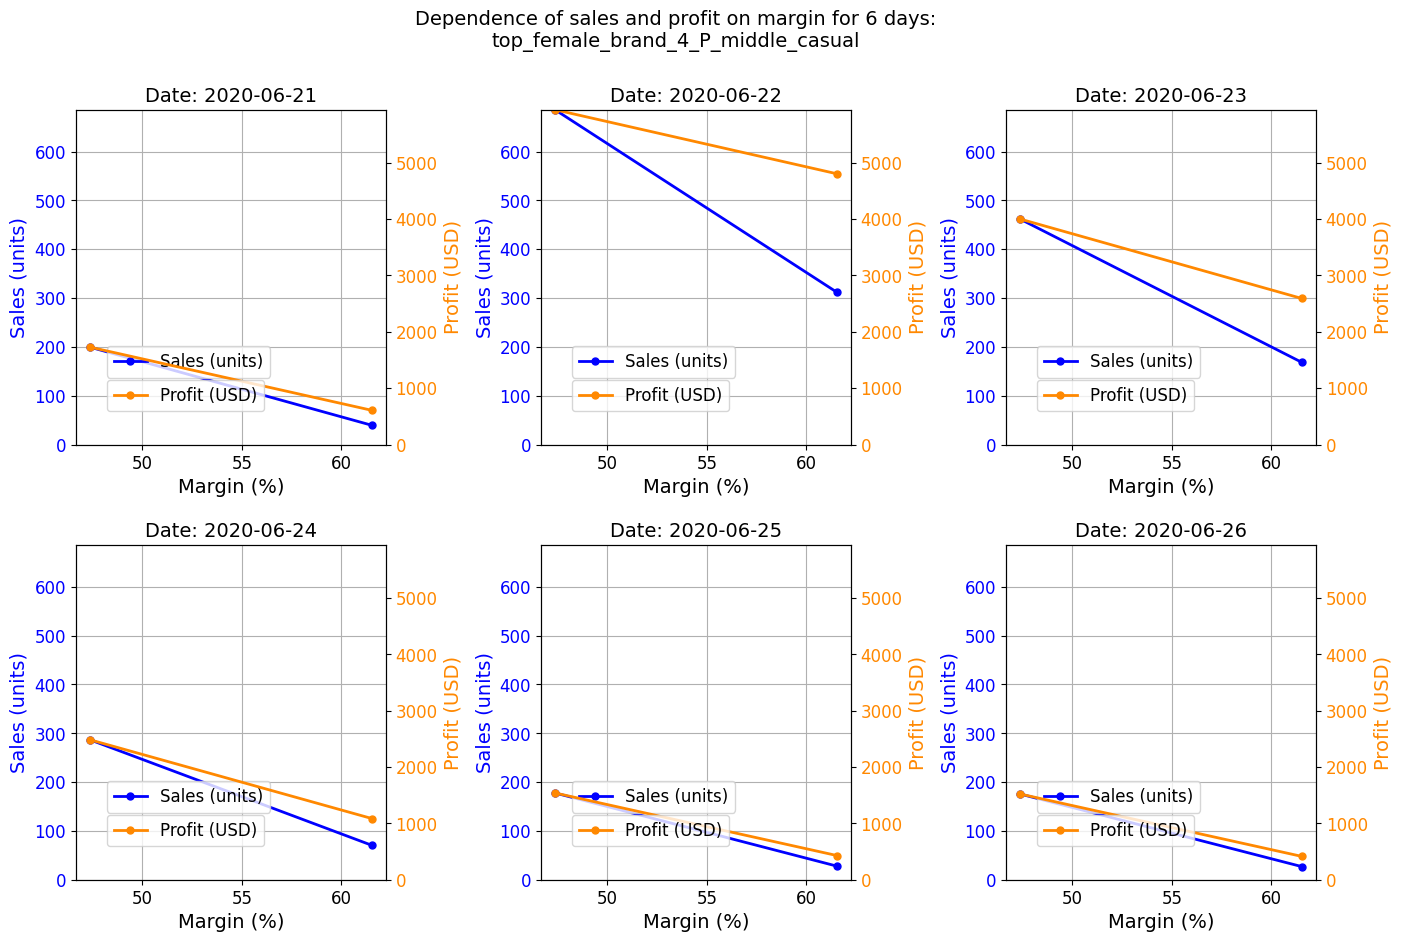

 ==> image saved to img-05-predicted_sales_profit-n_days.png


In [26]:
#
# Plot predicted sales & profit vs margin for 6 days
#
%matplotlib inline
import os
import csv
import datetime

PROFIT_COLOR = "#FF8800"
MS = 5  # marker size

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy import interpolate

def plot_ax_sales_income_on_margin(ax, df_day, max_y1=None, max_y2=None):
    df = df_day.copy()
    assert len(df["date"].unique()) == 1
    assert len(df["sku_name"].unique()) == 1

    df = df.reset_index(drop=True)  # Ensure a unique index
    df["margin"] = (df["price"] - 1.0) / df["price"]
    x = df["margin"] * 100
    y_sales = df["sales"]
    y_profit = df.apply(evaluate_profit, axis=1)

    # Plot sales:
    ax.set_xlabel("Margin (%)")
    ax.set_ylabel("Sales (units)", color=SALES_COLOR)
    ax.tick_params(axis='y', labelcolor=SALES_COLOR)
    #
    ax.plot(x, y_sales, "o-", color=SALES_COLOR, lw=2, ms=MS, label="Sales (units)")

    # Plot profit:
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel("Profit (USD)", color=PROFIT_COLOR)
    ax2.tick_params(axis='y', labelcolor=PROFIT_COLOR)
    #
    ax2.plot(x, y_profit, "o-", color=PROFIT_COLOR, lw=2, ms=MS, label="Profit (USD)")

    if max_y1 is not None:
        ax.set_ylim(0., max_y1)
    if max_y2 is not None:
        ax2.set_ylim(0., max_y2)

    ax.legend(loc=(0.1, 0.2))
    ax2.legend(loc=(0.1, 0.1))

    return


# Get predictions for the single SKU:
idx = df_predictions["sku_name"] == SKU_NAME
df = df_predictions[idx].reset_index(drop=True)
df["sales"] = df["predicted_sales"]
dates = np.sort(df["date"].unique())

# Get first 6 days
dates = dates[0:6]
idx = df["date"].isin(dates)
df = df[idx]

# Get y1, y2 maximal values over all selected days:
max_y1 = df["sales"].max()
df["profit"] = df.apply(evaluate_profit, axis=1)
max_y2 = df["profit"].max()

fig_size = (16, 10)
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=fig_size)
plt.subplots_adjust(wspace=0.5, hspace=0.3)

fig.suptitle(f"Dependence of sales and profit on margin for 6 days:\n{SKU_NAME}")

ij = 0
df_ij_lst = []  # for the next cell
for i in range(2):
    for j in range(3):
        date_ij = dates[ij]
        idx_ij = df["date"] == date_ij
        df_ij = df[idx_ij]

        ax_ij = axs[i, j]
        date_ij = pd.to_datetime(date_ij)
        ax_ij.set_title(f"Date: {date_ij:%Y-%m-%d}")
        ax_ij.grid()
        plot_ax_sales_income_on_margin(
            ax_ij, df_day=df_ij, max_y1=max_y1, max_y2=max_y2)

        df_ij_lst.append(df_ij)
        ij += 1

    #   Final plotting:
ax.legend(loc="upper left")
plt.show()
if IMAGE_DIR is not None:
    img_path = f"{IMAGE_PREFIX}05-predicted_sales_profit-n_days{IMAGE_POSTFIX}"
    fig.savefig(img_path, bbox_inches='tight')
    print(f" ==> image saved to {img_path}")



# Price Optimization

For each of the 6 days, we interpolate the dependence of the profit on the margin (price) and find the value of the margin corresponding to the maximal profit. Then we plot these values.

In [27]:
#
# Calculate and plot optimal margin values by date
#
def calc_optim_margin(df):
    assert "profit" in df.columns
    assert "margin" in df.columns

    margin = df["margin"].values
    profit = df["profit"].values

    # Interpolate profit:
    func_ipol = interpolate.interp1d(x=margin, y=profit, kind="quadratic")
    nv = 200
    margin_ipol = np.linspace(margin.min(), margin.max(), nv+1)
    profit_ipol = func_ipol(margin_ipol)
    i_max = np.argmax(profit_ipol)
    optim_margin = margin_ipol[i_max]

    return optim_margin

# Calculate optimal margin values by date:
date_lst = []
optim_margin_lst = []
ij = 0
for i in range(2):
    for j in range(3):
        df_ij = df_ij_lst[ij]

        assert len(df_ij["date"].unique()) == 1
        date_ij = df_ij["date"].iloc[0]
        date_lst.append(pd.to_datetime(date_ij))

        df_ij["margin"] = (df_ij["price"] - 1.0) / df_ij["price"] * 100
        optim_margin_ij = calc_optim_margin(df_ij)
        optim_margin_lst.append(optim_margin_ij)

        ij += 1

#   Plot optimal margin values by date:

MARGIN_COLOR = "#FF00FF"
fig_size = (12, 6)

x = np.array(date_lst)
y = np.array(optim_margin_lst)

fig, (ax) = plt.subplots(ncols=1, nrows=1, figsize=fig_size)

ax.set_title(f"Optimal margin by date for {SKU_NAME}")
ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_xlabel("Date")
ax.set_ylabel("Optimal margin (%)")
ax.grid()

ax.plot(x, y, "o-", color=MARGIN_COLOR, ms=5, lw=1, label="Optimal margin")
ax.legend(loc="upper left")
plt.show()
if IMAGE_DIR is not None:
    img_path = f"{IMAGE_PREFIX}06-optimal_prices_by_day{IMAGE_POSTFIX}"
    fig.savefig(img_path, bbox_inches='tight')
    print(f" ==> image saved to {img_path}")


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ValueError: The number of derivatives at boundaries does not match: expected 1, got 0+0

# Advanced Scenarios

For the illustration purposes, we show how profit function can be visualized for a group of potemtially interdependent SKUs.

### Joint optimization of two margins

We choose 2 SKUs and calculate the dependence of the predicted profit on the margin for each SKU via interpolation. Then we plot the total profit as a function of the two variables - margins for each SKU. The value of the profit is depicted by color. This illustrates the opportunity of joint optimization of margins for pairs of interacting SKUs.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


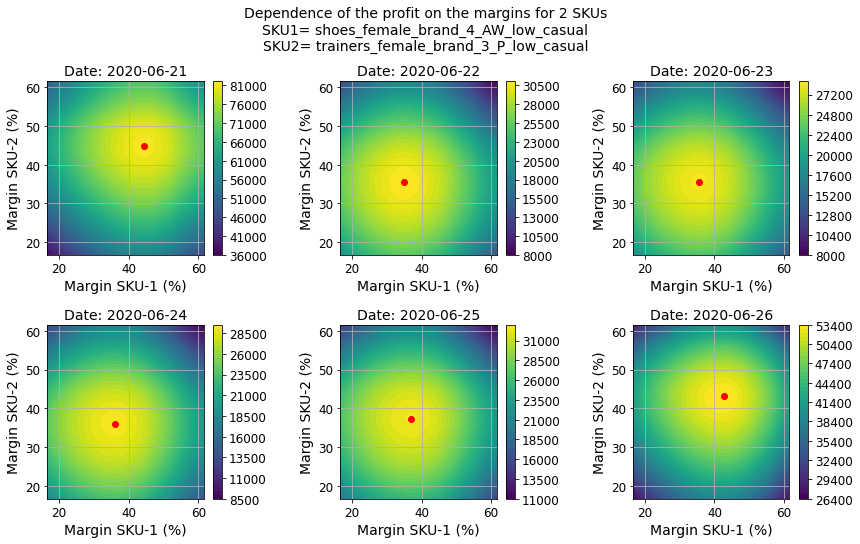

 ==> image saved to img-07-optimal_prices_for_2_sku.png


In [ ]:
def get_predictions_sku(df_predictions, sku_name, n_days):
    """
    """
    #   Get predictions (DF) only for this SKU:
    idx = df_predictions["sku_name"] == sku_name
    df = df_predictions[idx]
    df["sales"] = df["predicted_sales"]

    # Get first n_days days
    dates = np.sort(df["date"].unique())
    dates = dates[0:n_days]
    idx = df["date"].isin(dates)
    df = df[idx]

    #  Enrich by "margin" and "profit" columns
    df["margin"] = (df["price"] - 1.0) / df["price"] * 100
    df["profit"] = df.apply(evaluate_profit, axis=1)

    return df #, dates


def plot_ax_profit_2d(ax_i, df1i, df2i, fig):
    """  df1i, df2i are one-day DFs for SKU1, SKU2
    """
    margin1 = df1i["margin"]
    margin2 = df2i["margin"]
    profit1 = df1i["profit"]
    profit2 = df2i["profit"]

    #   Prepare interpolators:
    f_ipol_1 = interpolate.interp1d(margin1, profit1, kind="quadratic")
    f_ipol_2 = interpolate.interp1d(margin2, profit2, kind="quadratic")

    nv = 100
    margins1 = np.linspace(margin1.min(), margin1.max(), nv+1)
    margins2 = np.linspace(margin2.min(), margin2.max(), nv+1)
    X, Y = np.meshgrid(margins1, margins2)
    Z = f_ipol_1(X) + f_ipol_2(Y)  # the sum of profits

    # Find the maximum x,y coordinates
    arg_max = np.argmax(Z)
    max_i1, max_i2 = np.unravel_index(arg_max, np.array(Z).shape)
    max_x = X[max_i1, max_i2]
    max_y = Y[max_i1, max_i2]

    # Plot a dot at the maximum position
    xx = np.array([max_x])
    yy = np.array([max_y])
    ax_i.plot(xx, yy, "o", color="red")

    cf = ax_i.contourf(X, Y, Z, levels=50)
    fig.colorbar(cf, ax=ax_i)
    return

n_days = 6
sku_name1 = "shoes_female_brand_4_AW_low_casual"
sku_name2 = "trainers_female_brand_3_P_low_casual"

df_predictions = read_csv_from_bucket(gcs_path=gcs_dir + "/predictions_1.csv")
df_predictions = df_predictions.sort_values(["sku_name", "date", "price"])


df1 = get_predictions_sku(df_predictions, sku_name1, n_days)
df2 = get_predictions_sku(df_predictions, sku_name2, n_days)

dates = sorted(df1["date"].unique())
assert len(dates) == 6  # the follwoing piece of code is for 6 days

fig_size = (14, 8)
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=fig_size)
plt.subplots_adjust(wspace=0.5, hspace=0.4)
fig.subplots_adjust(top=0.85)  # leave 15% for suptitle on the top

title = "Dependence of the profit on the margins for 2 SKUs"
title += f"\nSKU1= {sku_name1}"
title += f"\nSKU2= {sku_name2}"
fig.suptitle(title)

ij = 0
df_ij_lst = []  # for the next cell
for i in range(2):
    for j in range(3):
        date_ij = dates[ij]
        df1_ij = df1[df1["date"] == date_ij]
        df2_ij = df2[df2["date"] == date_ij]

        ax_ij = axs[i, j]
        date_ij = pd.to_datetime(date_ij)
        ax_ij.set_title(f"Date: {date_ij:%Y-%m-%d}")
        ax_ij.grid()
        ax_ij.set_xlabel("Margin SKU-1 (%)")
        ax_ij.set_ylabel("Margin SKU-2 (%)")

        plot_ax_profit_2d(ax_ij, df1_ij, df2_ij, fig)

        ij += 1

    #   Final plotting:
plt.show()
if IMAGE_DIR is not None:
    img_path = f"{IMAGE_PREFIX}07-optimal_prices_for_2_sku{IMAGE_POSTFIX}"
    fig.savefig(img_path, bbox_inches='tight')
    print(f" ==> image saved to {img_path}")

